# Codigo Principal
En este codigo se analiza la informacion del **Sistema 1**:
- Sistema de evolución patrimonial, de declaración de intereses y
constancia de presentación de declaración fiscal.

### Definicion de funciones: Cargar y procesar datos

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os

def create_folder(path):
    try:
        os.mkdir('results/')
    except:
        pass

    try:
        os.remove('results/'+path)
    except:
        pass

    try:
        os.mkdir('results/' + path)
    except:
        pass

def load_data(files_path: str, subset_len: int ):
    json_files = os.listdir(files_path)
    files_subset = json_files[:subset_len]
    all_data = []
    for ix,file_name in enumerate(files_subset):
        print(f"Loading file {ix}/{subset_len}")
        path = f"{files_path}/{file_name}"
        # Opening JSON file
        f = open(path)
        # returns JSON object as
        # a dictionary
        data = json.load(f)
        all_data += data
    return all_data


def parse_records(all_data):
    all_records = []
    for record in all_data:
        institucion = record['metadata']['institucion']
        nombre = record['declaracion']['situacionPatrimonial']['datosGenerales']['nombre']
        primerApellido = record['declaracion']['situacionPatrimonial']['datosGenerales']['primerApellido']
        segundoApellido = record['declaracion']['situacionPatrimonial']['datosGenerales']['segundoApellido']
        nombreEntePublico = record['declaracion']['situacionPatrimonial']['datosEmpleoCargoComision']['nombreEntePublico']
        areaAdscripcion = record['declaracion']['situacionPatrimonial']['datosEmpleoCargoComision']['areaAdscripcion']
        funcionPrincipal = record['declaracion']['situacionPatrimonial']['datosEmpleoCargoComision']['funcionPrincipal']
        fechaTomaPosesion = record['declaracion']['situacionPatrimonial']['datosEmpleoCargoComision']['fechaTomaPosesion']
        totalIngresosNeto = record['totalIngresosNeto']
        local_info = [institucion, fechaTomaPosesion, nombre, primerApellido, segundoApellido, nombreEntePublico, areaAdscripcion, funcionPrincipal, totalIngresosNeto]
        all_records.append(local_info)

    columns = [
        'institucion',
        'fechaTomaPosesion',
        'nombre',
        'primerApellido',
        'segundoApellido',
        'nombreEntePublico',
        'areaAdscripcion',
        'funcionPrincipal',
        'totalIngresosNeto']
    all_records_df = pd.DataFrame(all_records,columns=columns)
    return all_records_df

### Definicion de funciones: Analysis con tabla detallada de outliers (top 20 de areas y puestos)

In [5]:
def analizar_top_categorias(df):
    """
    Este analysis toma en cuenta solamente los registros que son parte de las areaAdscripcion y
    funcionPrincipal mas frecuentes. En especifico los top 20 areaAdscripcion y funcionPrincipal
    con la mayor cantidad de ejemplos.
    Asi mismo, se detectan anomalias y se provee el detalle del registros de dichas anomalias
    """


    path_top_areas = 'analysis_top_areas/'
    create_folder(path_top_areas)

    # Assuming you have a DataFrame named 'df' with columns 'areaAdscripcion', 'totalIngresosNeto', and 'funcionPrincipal'

    # Example DataFrame
    # df = pd.DataFrame({'areaAdscripcion': ['Department1', 'Department2', 'Department1', 'Department3', 'Department2'],
    #                    'totalIngresosNeto': [50000, 60000, 55000, 70000, 65000],
    #                    'funcionPrincipal': ['Job1', 'Job2', 'Job1', 'Job3', 'Job2']})

    # Identify the top 20 most frequent areaAdscripcion and funcionPrincipal
    top_area = df['areaAdscripcion'].value_counts().nlargest(20).index
    top_funcion = df['funcionPrincipal'].value_counts().nlargest(20).index

    # Filter the DataFrame based on the top 20 areaAdscripcion
    df_area_filtered = df[df['areaAdscripcion'].isin(top_area)]

    # First Analysis: Group by 'areaAdscripcion' and create boxplot for top 20 totalIngresosNeto
    area_stats = df_area_filtered.groupby('areaAdscripcion')['totalIngresosNeto'].median().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    box = plt.boxplot([df_area_filtered[df_area_filtered['areaAdscripcion'] == area]['totalIngresosNeto'] for area in area_stats.index], labels=area_stats.index, flierprops=dict(markerfacecolor='r', marker='s'))
    plt.title('Top 20 areaAdscripcion based on Mean totalIngresosNeto (Filtered)')
    plt.xlabel('areaAdscripcion')
    plt.ylabel('totalIngresosNeto')

    # Rotate x-axis labels vertically
    plt.xticks(rotation='vertical')

    # Extract indices of outliers if they exist
    outlier_indices_area =  [flier.get_ydata()[0] for flier in box["fliers"] if len(flier.get_ydata())>0 ]

    # Store the records that count as outliers
    if outlier_indices_area:
        outliers_area = df_area_filtered.query(f"totalIngresosNeto.isin({outlier_indices_area})")
    else:
        outliers_area = pd.DataFrame()
        print("No outliers for areaAdscripcion")
    outliers_area.to_csv('results/' + path_top_areas + 'anomalias_top_20_ejemplos_areaAdscripcion.csv')

    #plt.show()
    plt.savefig('results/' + path_top_areas + 'distribucion_ingresos_top_20_ejemplos_areaAdscripcion.png')

    # Filter the DataFrame based on the top 20 funcionPrincipal
    df_funcion_filtered = df[df['funcionPrincipal'].isin(top_funcion)]

    # Second Analysis: Group by 'funcionPrincipal' and create boxplot for top 20 totalIngresosNeto
    funcion_stats = df_funcion_filtered.groupby('funcionPrincipal')['totalIngresosNeto'].mean().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    box = plt.boxplot([df_funcion_filtered[df_funcion_filtered['funcionPrincipal'] == func]['totalIngresosNeto'] for func in funcion_stats.index], labels=funcion_stats.index, flierprops=dict(markerfacecolor='r', marker='s'))
    plt.title('Top 20 funcionPrincipal based on Mean totalIngresosNeto (Filtered)')
    plt.xlabel('funcionPrincipal')
    plt.ylabel('totalIngresosNeto')

    # Rotate x-axis labels vertically
    plt.xticks(rotation='vertical')

    # Extract indices of outliers if they exist
    outlier_indices_funcion =  [flier.get_ydata()[0] for flier in box["fliers"] if len(flier.get_ydata())>0 ]

    # Store the records that count as outliers
    if outlier_indices_funcion:
        outliers_funcion = df_funcion_filtered.query(f"totalIngresosNeto.isin({outlier_indices_funcion})")
    else:
        print("\nNo outliers for funcionPrincipal")
        outliers_funcion = pd.DataFrame()
    outliers_funcion.to_csv('results/' + path_top_areas + 'anomalias_top_20_ejemplos_funcionPrincipal.csv')

    #plt.show()
    plt.savefig('results/' + path_top_areas + 'distribucion_ingresos_top_20_ejemplos_funcionPrincipal.png')

    print("Archivos analizados de forma exitosa! (top funciones)")
    print("Anomalias por funcion:", len(outliers_area))
    print("Anomalias por area:", len(outliers_funcion))


### Definicion de funciones: Analysis top ingresos (en areas y puestos)

In [40]:
def analizar_top_ingresos(df):
    """
    Este analysis toma en cuenta solamente los registros con el totalIngresosNeto mas alto.
    Se hace una agrupacion por areaAdscripcion y funcionPrincipal, quedandonos solemente con las
    areas y funciones que engloban el top 20 de los ingresos mas grandes.

    Asi mismo, se detectan anomalias y se provee el detalle del registros de dichas anomalias.
    """
    path_top_ingresos = 'analysis_top_ingresos/'
    create_folder(path_top_ingresos)

    # Assuming you have a DataFrame named 'df' with columns 'areaAdscripcion', 'totalIngresosNeto', and 'funcionPrincipal'

    # Example DataFrame
    # df = pd.DataFrame({'areaAdscripcion': ['Department1', 'Department2', 'Department1', 'Department3', 'Department2'],
    #                    'totalIngresosNeto': [50000, 60000, 55000, 70000, 65000],
    #                    'funcionPrincipal': ['Job1', 'Job2', 'Job1', 'Job3', 'Job2']})

    # Group by 'areaAdscripcion' and calculate median totalIngresosNeto
    area_grouped = df.groupby('areaAdscripcion')['totalIngresosNeto'].median()

    # Select the top 20 areaAdscripcion with the highest median totalIngresosNeto
    top_area_df = df[df['areaAdscripcion'].isin(area_grouped.nlargest(20).index)]

    # Group by 'funcionPrincipal' and calculate median totalIngresosNeto
    funcion_grouped = df.groupby('funcionPrincipal')['totalIngresosNeto'].median()

    # Select the top 20 funcionPrincipal with the highest median totalIngresosNeto
    top_funcion_df = df[df['funcionPrincipal'].isin(funcion_grouped.nlargest(20).index)]

    # First Analysis: Group by 'areaAdscripcion' and create boxplot for top 20 totalIngresosNeto
    area_stats = top_area_df.groupby('areaAdscripcion')['totalIngresosNeto'].median().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    box = plt.boxplot([top_area_df[top_area_df['areaAdscripcion'] == area]['totalIngresosNeto'] for area in area_stats.index], labels=area_stats.index)
    plt.title('Top 20 areaAdscripcion based on Median totalIngresosNeto')
    plt.xlabel('areaAdscripcion')
    plt.ylabel('totalIngresosNeto')

    # Rotate x-axis labels vertically
    plt.xticks(rotation='vertical')

    # Extract indices of outliers if they exist
    outlier_indices_area = [flier.get_ydata()[0] for flier in box["fliers"] if len(flier.get_ydata()) > 0]

    # Store the records that count as outliers
    if outlier_indices_area:
        outliers_area = top_area_df.query(f"totalIngresosNeto.isin({outlier_indices_area})")
    else:
        outliers_area = pd.DataFrame()
    outliers_area.to_csv('results/' + path_top_ingresos + 'anomalias_top_20_ingresos_areaAdscripcion.csv')

    #plt.show()
    plt.savefig('results/' + path_top_ingresos + 'distribucion_ingresos_top_20_ingresos_areaAdscripcion.png')

    # Second Analysis: Group by 'funcionPrincipal' and create boxplot for top 20 totalIngresosNeto
    funcion_stats = top_funcion_df.groupby('funcionPrincipal')['totalIngresosNeto'].median().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    box = plt.boxplot([top_funcion_df[top_funcion_df['funcionPrincipal'] == func]['totalIngresosNeto'] for func in funcion_stats.index], labels=funcion_stats.index)
    plt.title('Top 20 funcionPrincipal based on Median totalIngresosNeto')
    plt.xlabel('funcionPrincipal')
    plt.ylabel('totalIngresosNeto')

    # Rotate x-axis labels vertically
    plt.xticks(rotation='vertical')

    # Extract indices of outliers if they exist
    outlier_indices_funcion = [flier.get_ydata()[0] for flier in box["fliers"] if len(flier.get_ydata()) > 0]

    # Store the records that count as outliers
    if outlier_indices_funcion:
        outliers_funcion = top_funcion_df.query(f"totalIngresosNeto.isin({outlier_indices_funcion})")
    else:
        outliers_funcion = pd.DataFrame()
    outliers_funcion.to_csv('results/' + path_top_ingresos + 'anomalias_top_20_ingresos_funcionPrincipal.csv')

    #plt.show()
    plt.savefig('results/' + path_top_ingresos + 'distribucion_ingresos_top_20_ingresos_funcionPrincipal.png')
    print("Archivos analizados de forma exitosa! (top ingresos)")
    print("Anomalias por funcion:", len(outliers_area))
    print("Anomalias por area:", len(outliers_funcion))


### Usar funciones

#### Cargar archivos

In [36]:
files_path = "/datos/s1/Puebla"
all_data = load_data(files_path, subset_len = 100)
df = parse_records(all_data)

Loading file 0/400
Loading file 1/400
Loading file 2/400
Loading file 3/400
Loading file 4/400
Loading file 5/400
Loading file 6/400
Loading file 7/400
Loading file 8/400
Loading file 9/400
Loading file 10/400
Loading file 11/400
Loading file 12/400
Loading file 13/400
Loading file 14/400
Loading file 15/400
Loading file 16/400
Loading file 17/400
Loading file 18/400
Loading file 19/400
Loading file 20/400
Loading file 21/400
Loading file 22/400
Loading file 23/400
Loading file 24/400
Loading file 25/400
Loading file 26/400
Loading file 27/400
Loading file 28/400
Loading file 29/400
Loading file 30/400
Loading file 31/400
Loading file 32/400
Loading file 33/400
Loading file 34/400
Loading file 35/400
Loading file 36/400
Loading file 37/400
Loading file 38/400
Loading file 39/400
Loading file 40/400
Loading file 41/400
Loading file 42/400
Loading file 43/400
Loading file 44/400
Loading file 45/400
Loading file 46/400
Loading file 47/400
Loading file 48/400
Loading file 49/400
Loading fi

#### Correr Analysis

Archivos analizados de forma exitosa! (top funciones)
Anomalias por funcion: 109
Anomalias por area: 239


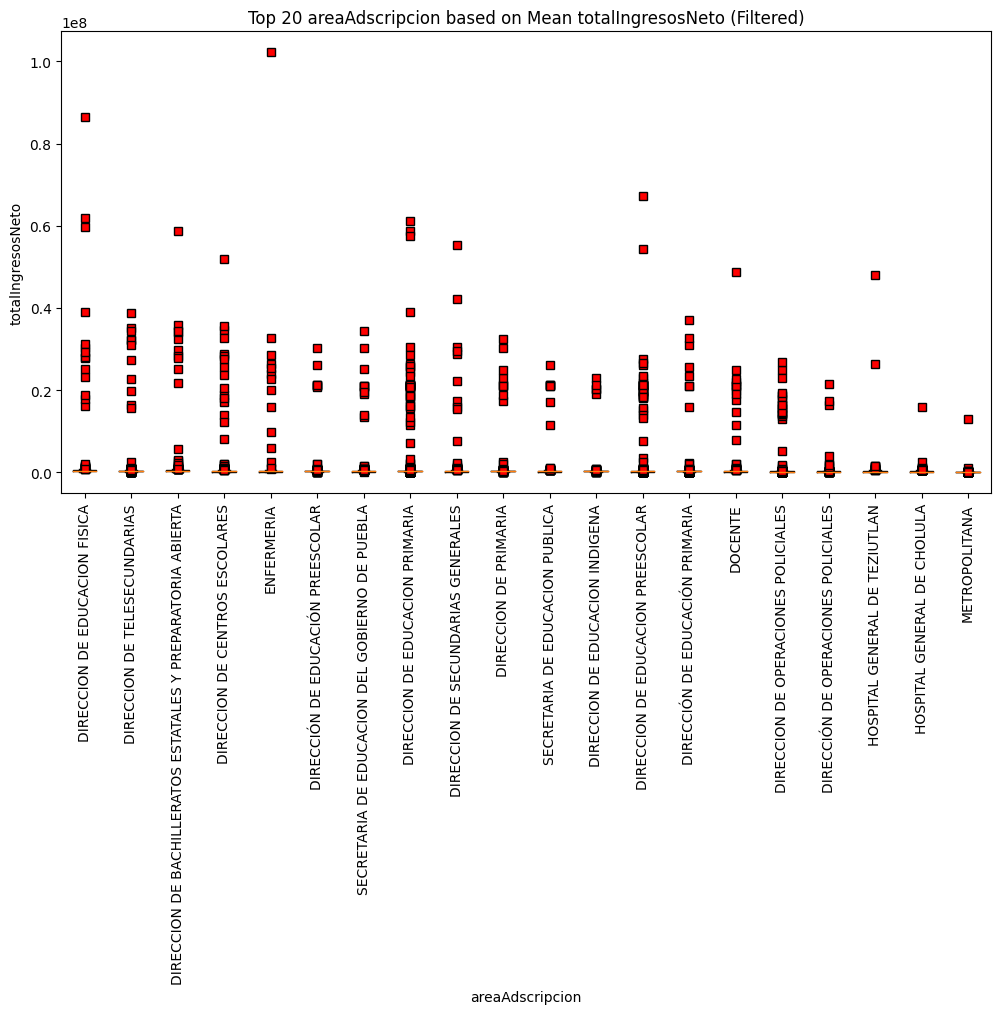

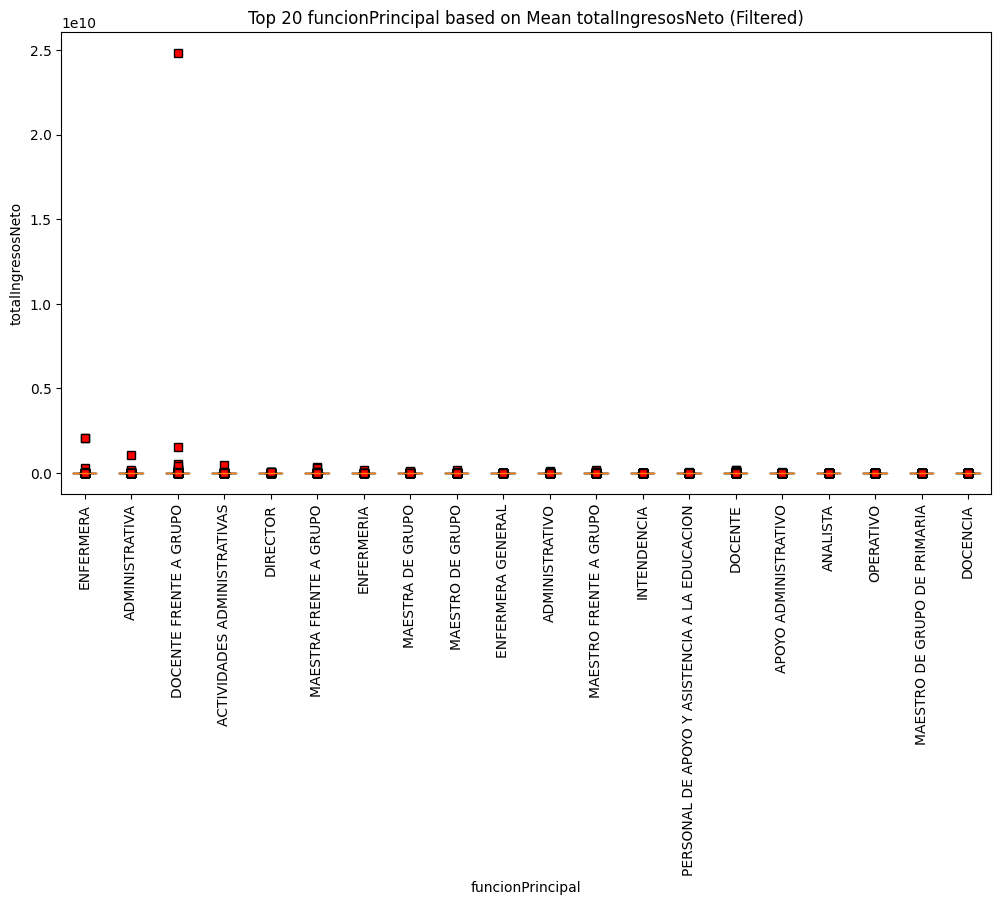

In [42]:
analizar_top_categorias(df)

Archivos analizados de forma exitosa! (top ingresos)
Anomalias por funcion: 0
Anomalias por area: 0


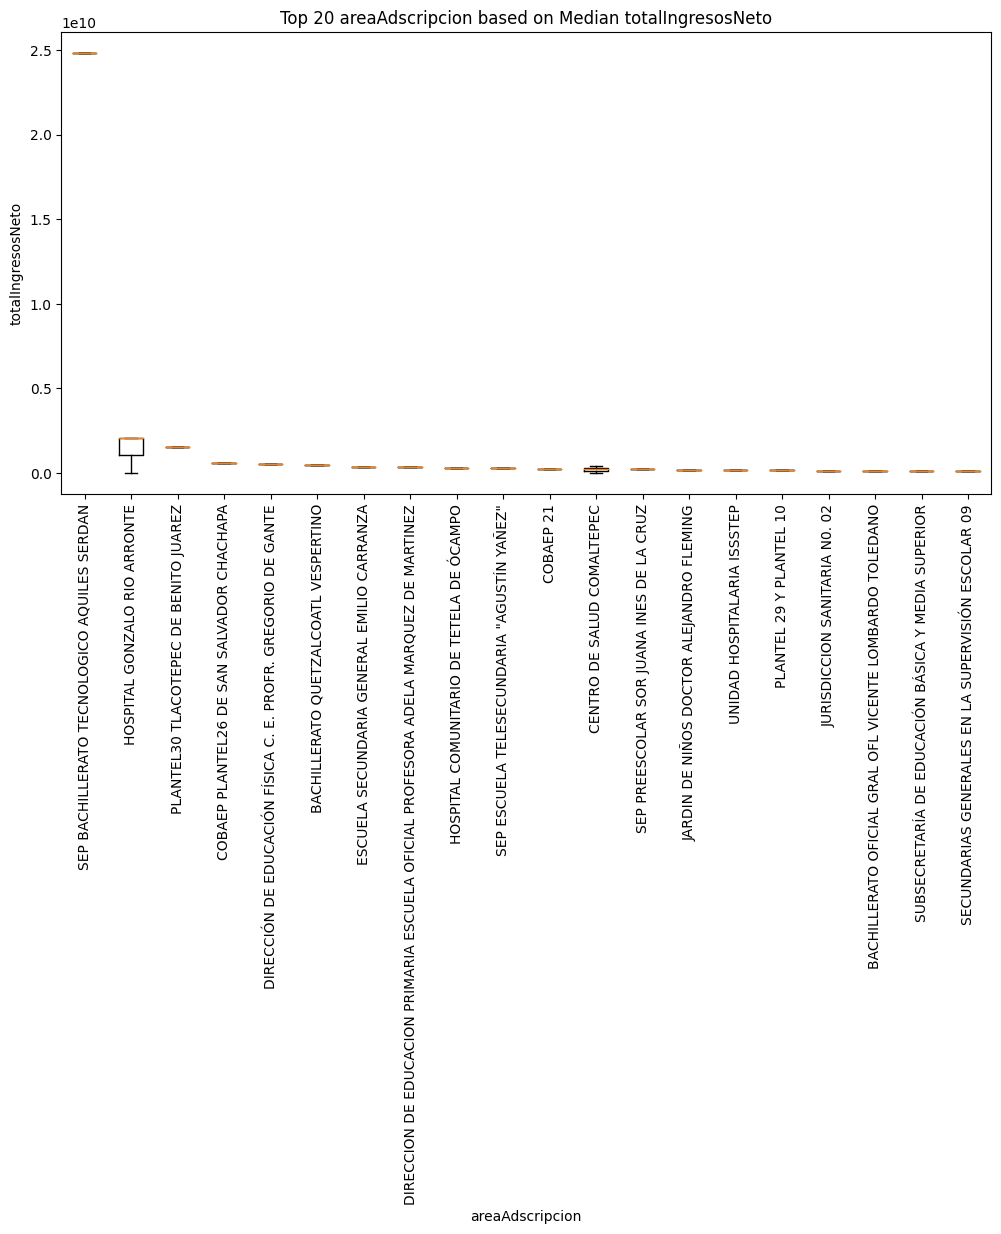

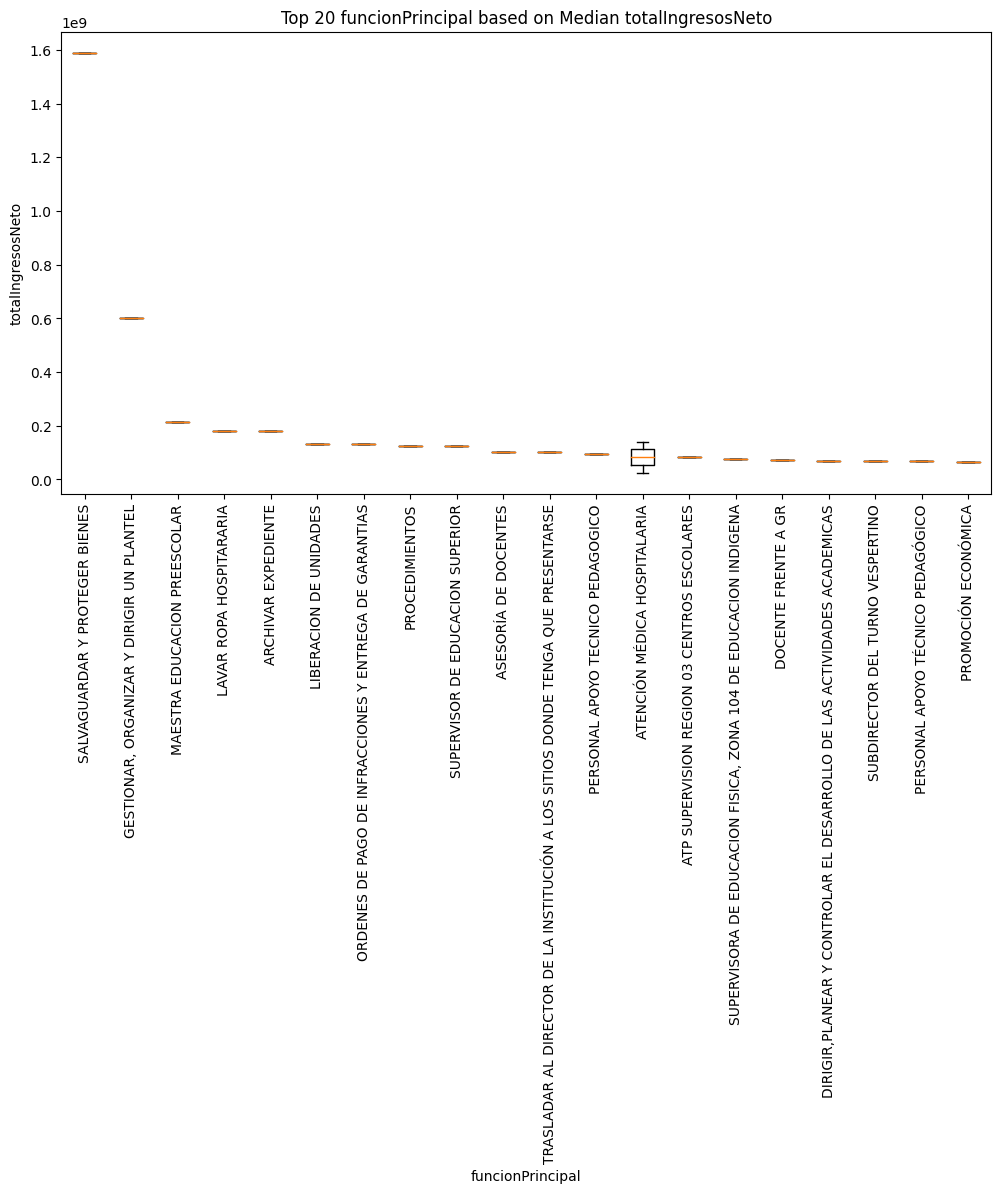

In [43]:
analizar_top_ingresos(df)

# Analisis extra: registros duplicados

#### Instalar libreria

In [44]:
!pip install deepdiff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 1.5 MB/s eta 0:00:00


#### Codigo

In [72]:
import json
from deepdiff import DeepDiff

def comparador_de_registros(all_data, nombre=None, primerApellido=None, segundoApellido=None):
    """
    Dado el nombre de una persona, este codigo sirve para comparar la información de todos los
    campos. Con esto podemos identificar si hay registros potencialmente duplicados o anomalos
    """

    nombres_repetidos = df.groupby(['nombre', 'primerApellido', 'segundoApellido'])['institucion'].count().sort_values(ascending=False).reset_index()
    print("Top nombres repetidos:")
    display(nombres_repetidos.head())

    if nombre is None:
        print("Analizando top 1 de repetidos\n")
        nombre = nombres_repetidos.iloc[0]['nombre']
        primerApellido = nombres_repetidos.iloc[0]['primerApellido']
        segundoApellido = nombres_repetidos.iloc[0]['segundoApellido']

    elementos_filtrados = [ele for ele in all_data if ele['declaracion']['situacionPatrimonial']['datosGenerales']['nombre'] == nombre \
                                and ele['declaracion']['situacionPatrimonial']['datosGenerales']['primerApellido'] == primerApellido\
                                and ele['declaracion']['situacionPatrimonial']['datosGenerales']['segundoApellido'] == segundoApellido\
                        ]

    # Example list of JSON elements
    json_list = elementos_filtrados
    # Function to compare JSON elements and print differences
    def compare_json_elements(json_list):
        for i, json_elem1 in enumerate(json_list):
            for j, json_elem2 in enumerate(json_list):
                if i != j:  # Avoid comparing the same element
                    diff = DeepDiff(json_elem1, json_elem2)
                    if diff:
                        print(f"Differences between elements {i+1} and {j+1}:\n{json.dumps(diff, indent=2)}\n")
    # Compare JSON elements in the list
    print(compare_json_elements(json_list))


In [73]:
comparador_de_registros(all_data)

Top nombres repetidos:


,nombre,primerApellido,segundoApellido,institucion
0,BRENDA,LEON,KASUSKY,6
1,PASCUAL,RAMOS,MANZANO,4
2,GUADALUPE,LOPEZ,TORRES,4
3,BLANCA,HERNANDEZ,CRUZ,4
4,MARIA MAGDALENA,GOMEZ,PAREDES,4


Analizando top 1 de repetidos
Differences between elements 1 and 2:
{
  "values_changed": {
    "root['id']": {
      "new_value": "636be6c7b3146974df644055",
      "old_value": "636bf725b3146974df64441c"
    },
    "root['metadata']['actualizacion']": {
      "new_value": "2022-11-09T11:58:21Z",
      "old_value": "2022-11-09T12:59:45Z"
    },
    "root['declaracion']['situacionPatrimonial']['experienciaLaboral']['experiencia'][0]['fechaEgreso']": {
      "new_value": "2016-06-30",
      "old_value": "2020-06-30"
    },
    "root['declaracion']['situacionPatrimonial']['ingresos']['remuneracionAnualCargoPublico']['valor']": {
      "new_value": 182900,
      "old_value": 232800
    },
    "root['declaracion']['situacionPatrimonial']['ingresos']['ingresoAnualNetoDeclarante']['valor']": {
      "new_value": 182900,
      "old_value": 232800
    },
    "root['declaracion']['situacionPatrimonial']['ingresos']['totalIngresosAnualesNetos']['valor']": {
      "new_value": 182900,
      "old_v